In [ ]:
# package installation; only necessary if you don't have package
library("devtools")
install_github("lme4/lme4",dependencies=TRUE)
install.packages('arm')

# Setup

In [362]:
# import packages
library(lme4)
library(arm)
library(stringr)

In [363]:
# helper function(s)
get_prob_timecourse <- function(iv, DM, score) {
    objs = c('bed', 'bench', 'chair', 'table')
    trained_objs = unique(DM[['label']])
    control_objs = c()
    for (obj in objs){
        if (!is.element(obj, trained_objs)) {
            control_objs = append(control_objs, obj) }}

    t1 = trained_objs[1]
    t2 = trained_objs[2]
    c1 = trained_objs[1]
    c2 = control_objs[2]
    
    if (score == 't') {
        return(rowMeans(cbind(
            array(aggregate(DM[DM['label']==toString(t1),]['t1_prob'],
                            by=DM[DM['label']==toString(t1),][iv], mean)['t1_prob']),
            array(aggregate(DM[DM['label']==toString(t2),]['t2_prob'],
                            by=DM[DM['label']==toString(t2),][iv], mean)['t2_prob']))))
    } else if (score == 'f') {
        return(rowMeans(cbind(
            array(aggregate(DM[DM['label']==toString(t1),]['t2_prob'],
                            by=DM[DM['label']==toString(t1),][iv], mean)['t2_prob']),
            array(aggregate(DM[DM['label']==toString(t2),]['t1_prob'],
                            by=DM[DM['label']==toString(t2),][iv], mean)['t1_prob']))))
    } else {
        return(rowMeans(cbind(
            array(aggregate(DM[DM['label']==toString(t1),]['c1_prob'],
                            by=DM[DM['label']==toString(t1),][iv], mean)['c1_prob']),
            array(aggregate(DM[DM['label']==toString(t1),]['c2_prob'],
                            by=DM[DM['label']==toString(t1),][iv], mean)['c2_prob']),
            array(aggregate(DM[DM['label']==toString(t2),]['c1_prob'],
                            by=DM[DM['label']==toString(t2),][iv], mean)['c1_prob']),
            array(aggregate(DM[DM['label']==toString(t2),]['c2_prob'],
                            by=DM[DM['label']==toString(t2),][iv], mean)['c2_prob']))))
    }
}

get_trained_objs <- function(DM) {
    return(unique(DM[['label']]))
}

In [364]:
ALLDM = read.csv("logistic_timeseries_drawing_neural_4way_logged.csv", header = TRUE)
prepost = read.csv('neural_changes_by_surfroi_and_subject.csv', header = TRUE)

# make subject ids in prepost dataframe match format in ALLDM
newcol = integer(nrow(prepost['IDs']))
for (i in 1:nrow(prepost['IDs'])) {
    newcol[i] = as.numeric(substr(prepost['IDs'][i,1], 0, 7))}
prepost['IDs'] = newcol
subs = unique(ALLDM['subj'])
rois = unique(ALLDM['roi'])

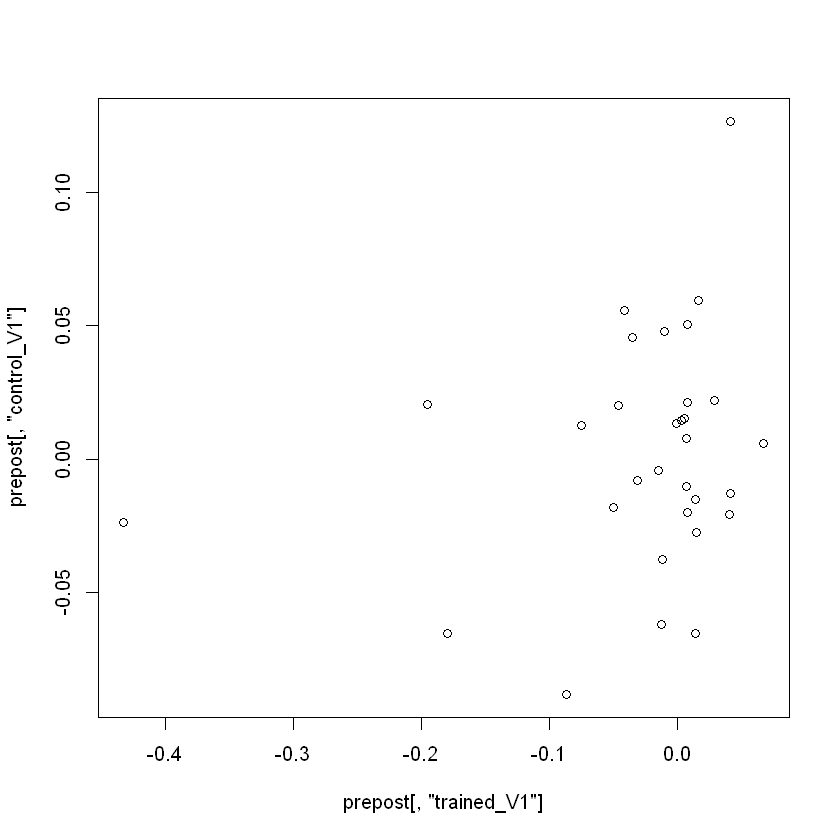

In [365]:
# quick sanity check: does this look like judy's?
plot(prepost[,'trained_V1'], prepost[,'control_V1'])

# Make the Data Frame

diff,selectivity,object_assignment
0.019554990,0.21378238,bedbench
-0.070490518,0.24487542,chairbed
0.013465994,-0.02642429,tablebed
-0.140920330,0.53382381,benchchair
-0.017790068,0.12025180,benchtable
-0.028008770,-0.81801985,tablechair
-0.022598529,-0.69826519,chairbed
-0.041107531,1.43940415,benchchair
0.073080889,0.44644002,benchtable
-0.045690825,-0.65671144,tablechair


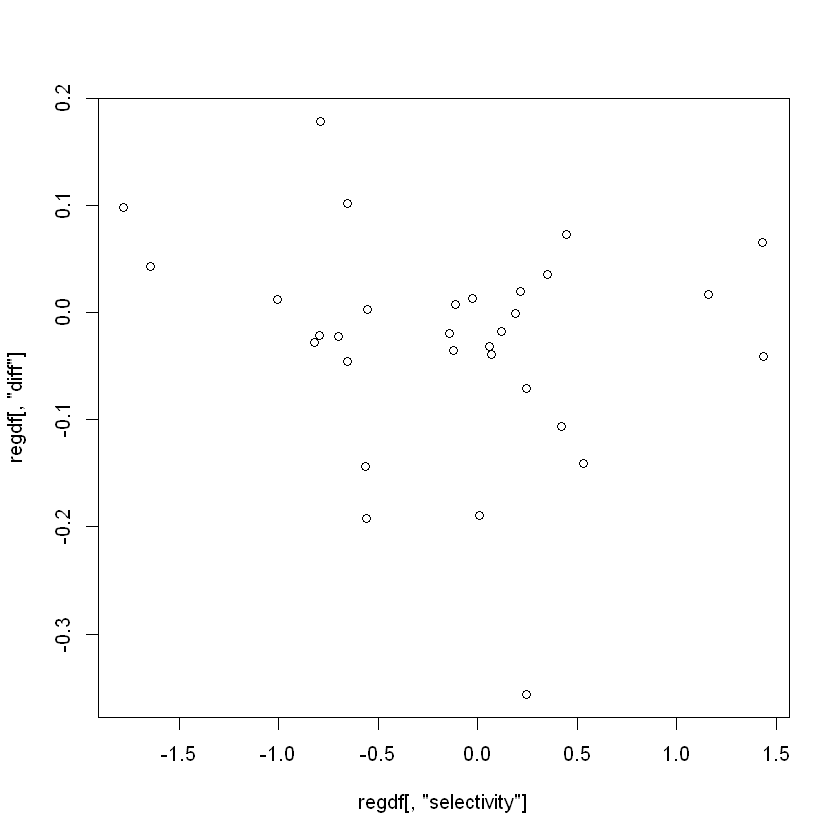

In [366]:
# single roi version
roi = 'V1'

# target selectivity
selectivity = c()
for (sub in subs[,]) {
    inds = (ALLDM['roi']==roi) & (ALLDM['subj']==sub)
    selectivity = append(selectivity,
                         mean(get_prob_timecourse('trial_num', ALLDM[inds,], 't')-
                              get_prob_timecourse('trial_num', ALLDM[inds,], 'f')))}

# training pair
object_assignment = c()
for (sub in subs[,]) {
    inds = (ALLDM['subj']==sub)
    object_assignment = append(object_assignment, str_remove(toString(get_trained_objs(ALLDM[inds,])), ', '))}

# prepost differentiation
diff = prepost[,sprintf('tradiff_%s', roi)]-prepost[,sprintf('condiff_%s', roi)]
#diff = prepost[,sprintf('trained_%s', roi)]-prepost[,sprintf('control_%s', roi)]

regdf = data.frame(diff, selectivity, object_assignment)
regdf['object_assignment'] = as.factor(unlist(regdf['object_assignment']))
regdf
plot(regdf[,'selectivity'], regdf[,'diff'])

# Model Fitting

In [367]:
OLSexamp <- lmer(diff ~ selectivity + (selectivity | object_assignment), data = regdf)
summary(OLSexamp)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"unable to evaluate scaled gradient"Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge: degenerate  Hessian with 1 negative eigenvalues"

Linear mixed model fit by REML ['lmerMod']
Formula: diff ~ selectivity + (selectivity | object_assignment)
   Data: regdf

REML criterion at convergence: -44.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1589 -0.2892  0.1448  0.5604  1.8311 

Random effects:
 Groups            Name        Variance Std.Dev. Corr
 object_assignment (Intercept) 0.000000 0.00000      
                   selectivity 0.003176 0.05636   NaN
 Residual                      0.009306 0.09647      
Number of obs: 31, groups:  object_assignment, 6

Fixed effects:
            Estimate Std. Error t value
(Intercept) -0.04317    0.02051  -2.105
selectivity -0.01514    0.03663  -0.413

Correlation of Fixed Effects:
            (Intr)
selectivity 0.062 
convergence code: 0
unable to evaluate scaled gradient
Model failed to converge: degenerate  Hessian with 1 negative eigenvalues


In [368]:
coef(OLSexamp)

$object_assignment
           (Intercept)  selectivity
bedbench   -0.04316847 -0.035370927
benchchair -0.04316847 -0.006164320
benchtable -0.04316847  0.035608101
chairbed   -0.04316847 -0.028614558
tablebed   -0.04316847  0.001167374
tablechair -0.04316847 -0.057450822

attr(,"class")
[1] "coef.mer"